In [1]:
!pip install pygame pyvirtualdisplay

  Using cached PyVirtualDisplay-3.0-py3-none-any.whl.metadata (943 bytes)
Using cached PyVirtualDisplay-3.0-py3-none-any.whl (15 kB)


In [5]:
!apt install swig && pip install gymnasium box2d box2d-kengz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  swig4.0
Suggested packages:
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  swig swig4.0
0 upgraded, 2 newly installed, 0 to remove and 35 not upgraded.
Need to get 1,116 kB of archives.
After this operation, 5,542 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig4.0 amd64 4.0.2-1ubuntu1 [1,110 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig all 4.0.2-1ubuntu1 [5,632 B]
Fetched 1,116 kB in 0s (4,351 kB/s)
Selecting previously unselected package swig4.0.
(Reading database ... 126111 files and directories currently installed.)
Preparing to unpack .../swig4.0_4.0.2-1ubuntu1_amd64.deb ...
Unpacking swig4.0 (4.0.2-1ubuntu1) ...
Selecting previously unselected package swig.
Preparing to unpack .../swig_4.0.2-1ubu

In [6]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display, HTML
import base64
import os

In [7]:
gym.pprint_registry()

===== classic_control =====
Acrobot-v1             CartPole-v0            CartPole-v1
MountainCar-v0         MountainCarContinuous-v0 Pendulum-v1
===== phys2d =====
phys2d/CartPole-v0     phys2d/CartPole-v1     phys2d/Pendulum-v0
===== box2d =====
BipedalWalker-v3       BipedalWalkerHardcore-v3 CarRacing-v3
LunarLander-v3         LunarLanderContinuous-v3
===== toy_text =====
Blackjack-v1           CliffWalking-v0        FrozenLake-v1
FrozenLake8x8-v1       Taxi-v3
===== tabular =====
tabular/Blackjack-v0   tabular/CliffWalking-v0
===== mujoco =====
Ant-v2                 Ant-v3                 Ant-v4
Ant-v5                 HalfCheetah-v2         HalfCheetah-v3
HalfCheetah-v4         HalfCheetah-v5         Hopper-v2
Hopper-v3              Hopper-v4              Hopper-v5
Humanoid-v2            Humanoid-v3            Humanoid-v4
Humanoid-v5            HumanoidStandup-v2     HumanoidStandup-v4
HumanoidStandup-v5     InvertedDoublePendulum-v2 InvertedDoublePendulum-v4
InvertedDoublePendulu

In [20]:
env = gym.make("MountainCar-v0", render_mode="rgb_array")
print(env.observation_space)
print(env.action_space)

Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Discrete(3)


In [21]:
env.observation_space.shape

(2,)

In [22]:
obs_space_low_ar = env.observation_space.low
obs_space_high_ar = env.observation_space.high
arrays = []
for i in range(len(obs_space_low_ar)):
    arrays.append([obs_space_low_ar[i], obs_space_high_ar[i]])
obs_bounds = np.array(arrays)
print(obs_bounds)


[[-1.2   0.6 ]
 [-0.07  0.07]]


The action space is discrete with actions taking on values of 0 or 1 or 2. The observation space is a continuous but bounded space in R^2. Since this notebook is an implementation of tabular SARSA, we want to have a matrix of states x actions to hold the state-action value estimates. So, we need to discretize the observation space. As a simple heuristic, we can have the discretize the observation space by having 10 intervals for each of the 2 dimensions. So, there will be a total 100 states

In [38]:
import bisect
dim1_intervals = np.linspace(obs_bounds[0][0], obs_bounds[0][1], 26)[:25] #get the left bounds fo each of the 10 intervals for dim 1
dim2_intervals = np.linspace(obs_bounds[1][0], obs_bounds[1][1], 11)[:10] #get the left bounds of each of the 10 intervals for dim 2

def get_dim1_interval_idx(val):
    # returns the index in the discretized version of dim 1 that the current obs belongs to
    if val in dim1_intervals:
        return bisect.bisect_left(dim1_intervals, val)
    return bisect.bisect_left(dim1_intervals, val) - 1


def get_dim2_interval(val):
  # returns the index in the discretized version of dim 2 that the current obs belongs to
  if val in dim2_intervals:
        return bisect.bisect_left(dim2_intervals, val)
  return bisect.bisect_left(dim2_intervals, val) - 1

def convert_obs_to_state_idx(obs):
  return get_dim1_interval_idx(obs[0]) * 10 + get_dim2_interval(obs[1])


In [63]:
num_states = 25*10
num_actions = env.action_space.n
Q = np.random.normal(size=(num_states, num_actions))
alpha = .05 #implies that each update to a state-action value pair is 95% of the current value and 5% of the new value
gamma = .99 #discount factor on future rewards
num_episodes = 15000
epsilon = .1

In [64]:
for episode_idx in range(num_episodes):
  reward_sum = 0
  next_obs, _ = env.reset() #reset the env to get initial state

  #choose actionin an epsilon greedy manner
  if np.random.random() <= epsilon:
      next_action = env.action_space.sample()
  else:
      next_action = np.argmax(Q[convert_obs_to_state_idx(next_obs), :])


  done = False
  while not done:
      action = next_action
      obs = next_obs
      next_obs, reward, terminated, truncated, _ = env.step(action)
      reward_sum += reward
      if np.random.random() <= epsilon:
        next_action = env.action_space.sample()
      else:
        next_action = np.argmax(Q[convert_obs_to_state_idx(next_obs), :])
      done = terminated or truncated

      if not done:
        #update Q with state-action value estimate
        Q[convert_obs_to_state_idx(obs), action] += alpha * (reward + gamma * Q[convert_obs_to_state_idx(next_obs), next_action] - Q[convert_obs_to_state_idx(obs), action])
      else:
        Q[convert_obs_to_state_idx(obs), action] += alpha * (reward - Q[convert_obs_to_state_idx(obs), action])
        if episode_idx % 100 == 0:
          print(episode_idx, reward_sum, sep=': ')


env.close()


0: -200.0
100: -200.0
200: -200.0
300: -200.0
400: -200.0
500: -200.0
600: -200.0
700: -200.0
800: -200.0
900: -200.0
1000: -200.0
1100: -200.0
1200: -200.0
1300: -200.0
1400: -200.0
1500: -200.0
1600: -165.0
1700: -200.0
1800: -200.0
1900: -200.0
2000: -183.0
2100: -154.0
2200: -165.0
2300: -200.0
2400: -200.0
2500: -181.0
2600: -160.0
2700: -188.0
2800: -200.0
2900: -200.0
3000: -200.0
3100: -200.0
3200: -200.0
3300: -159.0
3400: -162.0
3500: -200.0
3600: -200.0
3700: -200.0
3800: -187.0
3900: -164.0
4000: -200.0
4100: -200.0
4200: -160.0
4300: -164.0
4400: -165.0
4500: -175.0
4600: -194.0
4700: -167.0
4800: -167.0
4900: -200.0
5000: -176.0
5100: -200.0
5200: -166.0
5300: -165.0
5400: -177.0
5500: -162.0
5600: -143.0
5700: -146.0
5800: -200.0
5900: -163.0
6000: -185.0
6100: -157.0
6200: -158.0
6300: -167.0
6400: -200.0
6500: -200.0
6600: -170.0
6700: -200.0
6800: -165.0
6900: -152.0
7000: -150.0
7100: -184.0
7200: -159.0
7300: -166.0
7400: -158.0
7500: -188.0
7600: -158.0
7700: -166.

-152.0


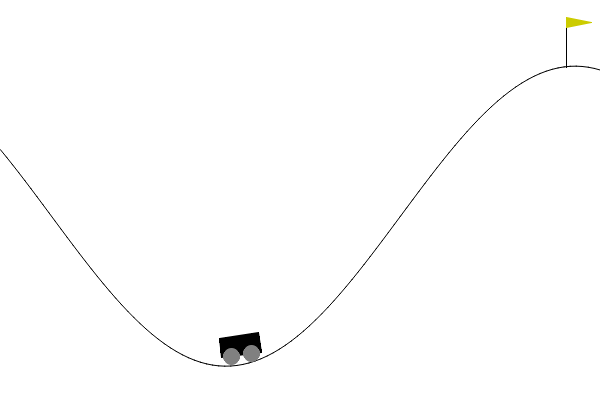

In [65]:
reward_sum = 0
next_obs, _ = env.reset() #reset the env to get initial state
next_action = np.argmax(Q[convert_obs_to_state_idx(next_obs), :])

frames = []

done = False
while not done:
    frame = env.render()
    frames.append(Image.fromarray(frame))
    action = next_action
    obs = next_obs
    next_obs, reward, terminated, truncated, _ = env.step(action)
    reward_sum += reward
    next_action = np.argmax(Q[convert_obs_to_state_idx(next_obs), :])
    done = terminated or truncated

env.close()
print(reward_sum)
# Save to GIF
frames[0].save("mountain_car.gif", save_all=True, append_images=frames[1:], duration=50, loop=0)

# Display the GIF in notebook
from IPython.display import Image as IPyImage
IPyImage(filename="mountain_car.gif")